## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

            0         1
0    0.754246  0.231481
1   -0.756159  0.153259
2   -0.815392  0.173282
3   -0.393731  0.692883
4    0.442208 -0.896723
..        ...       ...
995  0.244054  0.944125
996 -0.978655 -0.272373
997 -0.136900 -0.810012
998  0.670362 -0.767502
999  0.281057  0.963824

[1000 rows x 2 columns]
     0
0    1
1    1
2    1
3    1
4    0
..  ..
995  0
996  0
997  1
998  0
999  0

[1000 rows x 1 columns]
            0         1  0
0    0.754246  0.231481  1
1   -0.756159  0.153259  1
2   -0.815392  0.173282  1
3   -0.393731  0.692883  1
4    0.442208 -0.896723  0
..        ...       ... ..
995  0.244054  0.944125  0
996 -0.978655 -0.272373  0
997 -0.136900 -0.810012  1
998  0.670362 -0.767502  0
999  0.281057  0.963824  0

[1000 rows x 3 columns]


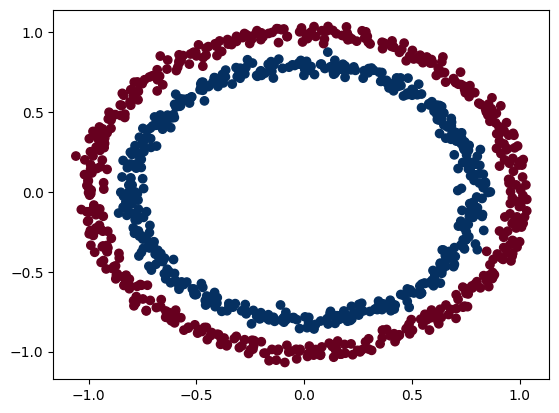

In [14]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import pandas as pd
n_samples = 1000
X, y = make_circles(n_samples= 1000,
    noise = 0.03,
    random_state = 42,
)
print(pd.DataFrame(X))
print(pd.DataFrame(y))
print(pd.concat([pd.DataFrame(X),pd.DataFrame(y)], axis = 1))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu);

In [15]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 비선형성을 갖는 모델 구축

In [26]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))
    
model_3 = CircleModelV2().to(device)
print(model_3)
print(device)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)
cuda


In [27]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [36]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal     
    acc = (correct / len(y_pred)) * 100             # torch.eq(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]])) -> tensor([[ True, False], [False, True]])
    return acc

In [39]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)   # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
     ### Testing
    model_3.eval()
    with torch.inference_mode():
         # 1. Forward pass
         test_logits = model_3(X_test).squeeze()
         test_pred = torch.round(torch.sigmoid(test_logits))
         # 2. Calculate loss and accuracy
         test_loss = loss_fn(test_logits, y_test)
         test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
         

# Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%") 
     
         
    
    


Epoch: 0 | Loss: 0.69422, Accuracy: 51.62% | Test Loss: 0.69329, Test Accuracy: 55.00%
Epoch: 100 | Loss: 0.69167, Accuracy: 51.38% | Test Loss: 0.69118, Test Accuracy: 54.00%
Epoch: 200 | Loss: 0.69081, Accuracy: 51.62% | Test Loss: 0.69007, Test Accuracy: 54.50%
Epoch: 300 | Loss: 0.68900, Accuracy: 52.25% | Test Loss: 0.68814, Test Accuracy: 57.50%
Epoch: 400 | Loss: 0.68620, Accuracy: 53.50% | Test Loss: 0.68544, Test Accuracy: 57.50%
Epoch: 500 | Loss: 0.68195, Accuracy: 56.25% | Test Loss: 0.68163, Test Accuracy: 60.00%
Epoch: 600 | Loss: 0.67412, Accuracy: 68.00% | Test Loss: 0.67581, Test Accuracy: 68.00%
Epoch: 700 | Loss: 0.65878, Accuracy: 85.25% | Test Loss: 0.66564, Test Accuracy: 80.00%
Epoch: 800 | Loss: 0.63073, Accuracy: 88.50% | Test Loss: 0.64424, Test Accuracy: 84.50%
Epoch: 900 | Loss: 0.57515, Accuracy: 91.62% | Test Loss: 0.59843, Test Accuracy: 88.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]  # d예측 레이블과 진짜 레이블을 같은 형태로 만든다.

(tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [42]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


#### model_3와 model_1 비교를 위한 model_1 불러오기

In [44]:
from sklearn.datasets import make_circles

# Make 1000 sample
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise =0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values 동일한 값을 얻기 위해

 #X,y를 나누는 이유 : X.shape(2,) 들의 점이 안쪽 원(0)인지 바깥 쪽 원(1) 인지 알아내기 위해 나눈다.
 
 # X,y가 어떻게 나눠질까? 

In [45]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [46]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [47]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

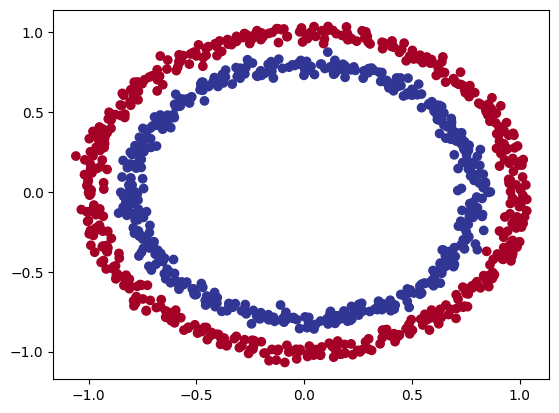

In [48]:
# 시각화 (visualize) with a plot
import matplotlib.pyplot as plt
plt.scatter(x= X[:, 0],
            y= X[:,1],
            c=y,  # 컬러를 y값에 따라 다르게 색칠해라
            cmap = plt.cm.RdYlBu)

In [49]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [50]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [51]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [52]:
# Split data into train and test sets 데이터 나누기

from sklearn.model_selection import train_test_split  # <- 배열이나 행렬을 무작위의 훈련 및 테스트 subset으로 나눈다

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,  # 20% test, 80% train
                                                    random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

#800 게의 학습 샘플과 200개의 테스트 샘플이 있다

(800, 200, 800, 200)

In [53]:
# Standard PyTorch imports
import torch 
from torch import nn

# Make device agnostic(독립적인) code
device = "cuda" if torch.cuda.is_available() else "cpu"


In [54]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes 2의 nn.Linear 생성
        self.layer_1 = nn.Linear(in_features =2, out_features =5)   #5개의 숫자에서 패던을 학습하여 더 나은 출력을 얻을 수 있도록(효과가 없을 수 있다)
        self.layer_2 = nn.Linear(in_features =5, out_features =1)   #히든 유닛의 규칙 이전 out_features 와 in_features와 같아야 함
        
         # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2
    
    
# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0
        
        

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [55]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0  #순차적 계산에 탁월

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [56]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape  : {untrained_preds.shape}")
print(f"Length of test samples : {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels: \n{y_test[:10]}")

Length of predictions: 200, shape  : torch.Size([200, 1])
Length of test samples : 200, Shape: torch.Size([200])

First 10 predictions: 
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [117]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [58]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal     
    acc = (correct / len(y_pred)) * 100             # torch.eq(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]])) -> tensor([[ True, False], [False, True]])
    return acc

In [59]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

In [60]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [61]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()  # 이건 아직 로짓(모델의  raw output), 그러니까 X_test의 5개를 그냥 넣었을 때 값을 시그모이드 함수를 이용해 예측 확률로 만들고 반올림(round)해서 예측 레이블로 변환
                   # 진짜 레이블 값과 비교가 되게 만든 것이다.

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [62]:
#진짜 레이블 값
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()  # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls 예측 레이블로 변환
    
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
                   y_train) 
    loss = loss_fn(y_logits,   # Using nn.BCEWithLogitsLoss works with raw logits 시그모이드가 들어있는 이진 교차 엔트로피이니까 raw logits을 넣기
                   y_train)
    
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ###Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred =test_pred)
        
        # Print out what's happening every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f},Test acc: {test_acc:.2f}%")
        
    
    
    
    
    

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69440,Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25% | Test loss: 0.69305,Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62% | Test loss: 0.69254,Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12% | Test loss: 0.69236,Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.88% | Test loss: 0.69232,Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25% | Test loss: 0.69234,Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00% | Test loss: 0.69239,Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25% | Test loss: 0.69246,Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.88% | Test loss: 0.69254,Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.88% | Test loss: 0.69262,Test acc: 53.00%


#### model_3 와 model_0 결정 경계 비교(잘못가지고 왔다)

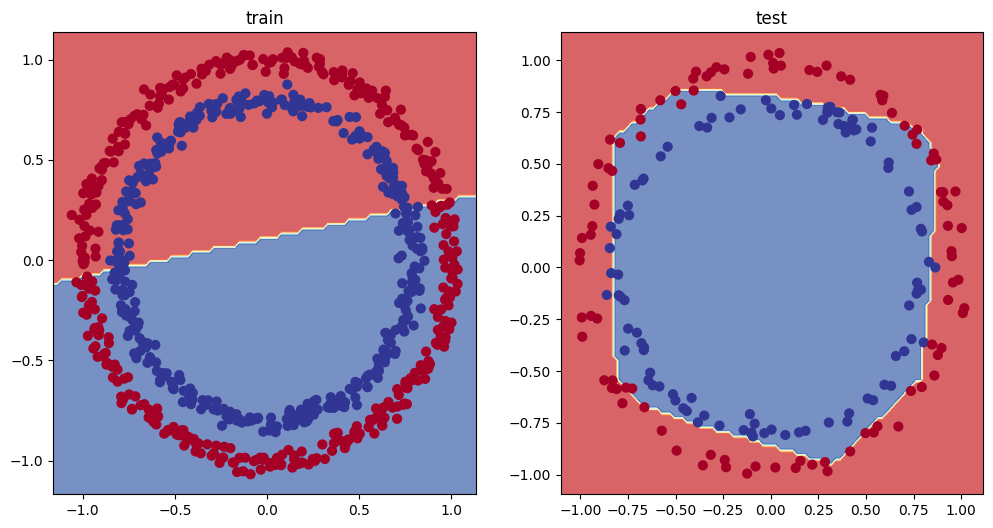

In [66]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0, X_train,y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_3,X_test, y_test)

## 7. Replicating(복제하다) non-linear activation functions

In [68]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

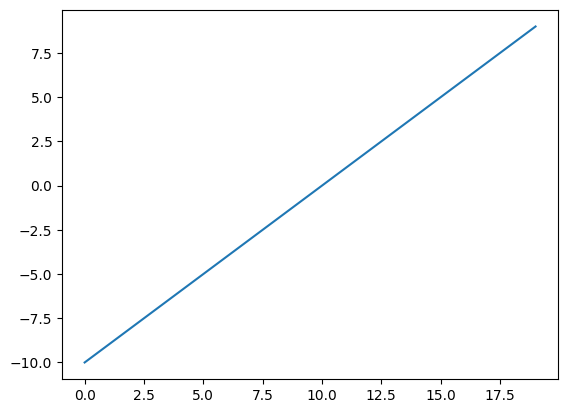

In [75]:

plt.plot(A)


In [76]:
# Create ReLU function by hand  #The ReLU function turns all negatives to 0 and leaves the positive values as they are.
def relu(x):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors # torch.maximum(a,b) 함수는 a,b를 비교해서 더 큰 값을 표시하는 것이다.

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

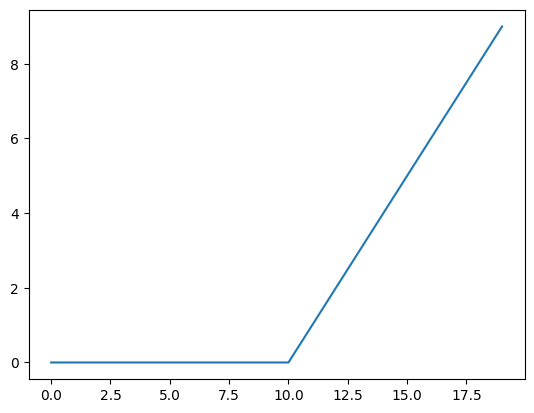

In [77]:
plt.plot(relu(A))

In [78]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1/(1+ torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

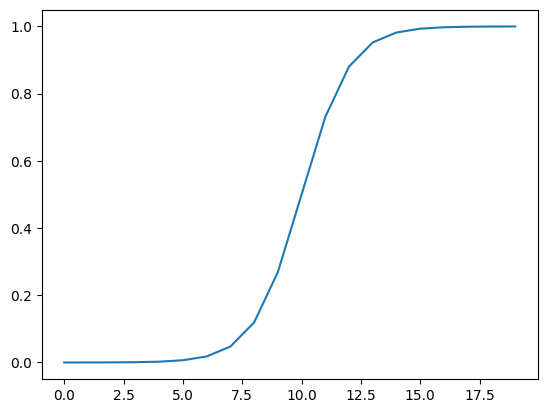

In [79]:
plt.plot(sigmoid(A))

## 8.1 Creating multi-class classification data

- 1.Create some multi-class data with make_blobs().
- 2.Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
- 3.Split the data into training and test sets using train_test_split().
- 4.Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


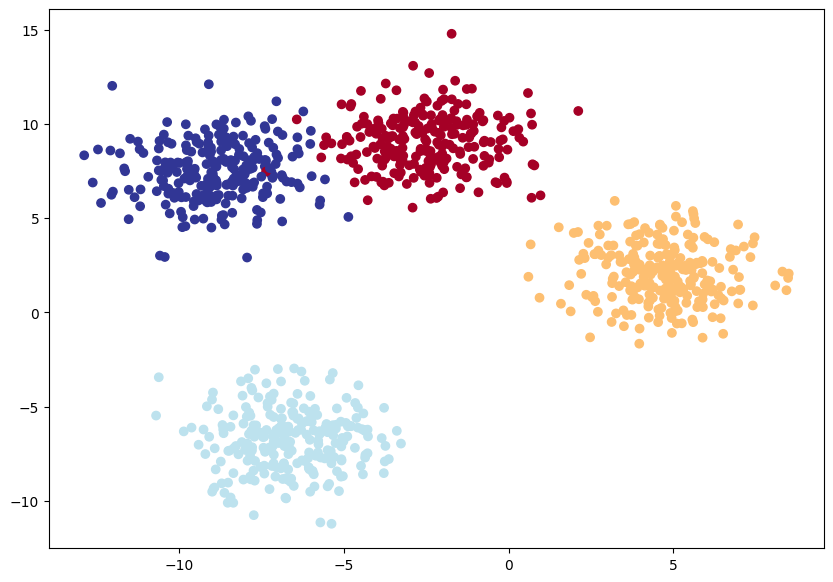

In [107]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES =4
NUM_FEATURES =2
RAMDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,  #n_samples : 표본 데이터의 수, 디폴트 100
                            n_features = NUM_FEATURES, # X features #n_features : 독립 변수의 수, 디폴트 20
                            centers = NUM_CLASSES,     # y labels #centers : 생성할 클러스터의 수 혹은 중심, [n_centers, n_features] 크기의 배열. 디폴트 3
                            cluster_std= 1.5,       # give the clusters a little shake up (try changing this to 1.0, the default) cluster_std: 클러스터의 표준 편차, 디폴트 1.0
                            random_state = RAMDOM_SEED)  #make_blobs를 사용하면 X_blobs : [n_samples, n_features] 크기의 배열: 독립 변수
#                                                                               y_blobs : [n_samples] 크기의 배열: 종속 변수
 
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)  # 실수
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # 정수
print(X_blob[:5],y_blob[:5]) 

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RAMDOM_SEED)

# 4. Plot data
plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c= y_blob, cmap = plt.cm.RdYlBu)


### 8.2 PyTorch에서 다중 클래스 분류 모델 구축

In [131]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [132]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,out_features = output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4
        

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [133]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]  # 지금 나오는 값은 logits, raw 값을 예측 레이블로 바꾸기 위해 소프트맥스 활성화 함수가 나옴

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [134]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) #차원이 나오는 이유는 뭘까? #입력이 다차원이기에 dim = 1 행을 기준으로 확률 분포 계산
print(y_logits[:5])
print(y_pred_probs[:5]) # 로짓을 소프트맥스 함수로 통과시킨 후, 각 개별 샘플의 합은 1(또는 그에 매우 가까운 값)이 됩니다.

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [135]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [136]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))


tensor([0.3169, 0.3244, 0.1405, 0.2182], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [138]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100
loss_fn = nn.BCEWithLogitsLoss()   #왜? BCEWithlogitsLoss는 안되는 걸까>
# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim =0 ).argmax(dim =1)
    print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train,
                      y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim =1).argmax(dim =1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test,
                               y_pred = test_pred)
                            
        
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        ...,
        [-0.2564, -1.2652, -1.0365, -0.3130],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.0502, -0.8423, -0.4798, -0.0988]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


ValueError: Target size (torch.Size([800])) must be the same as input size (torch.Size([800, 4]))

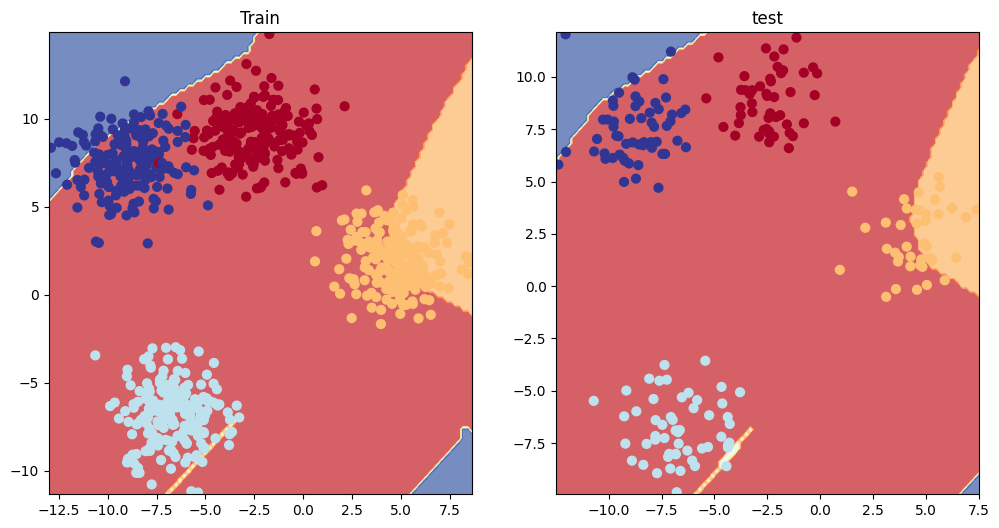

In [139]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

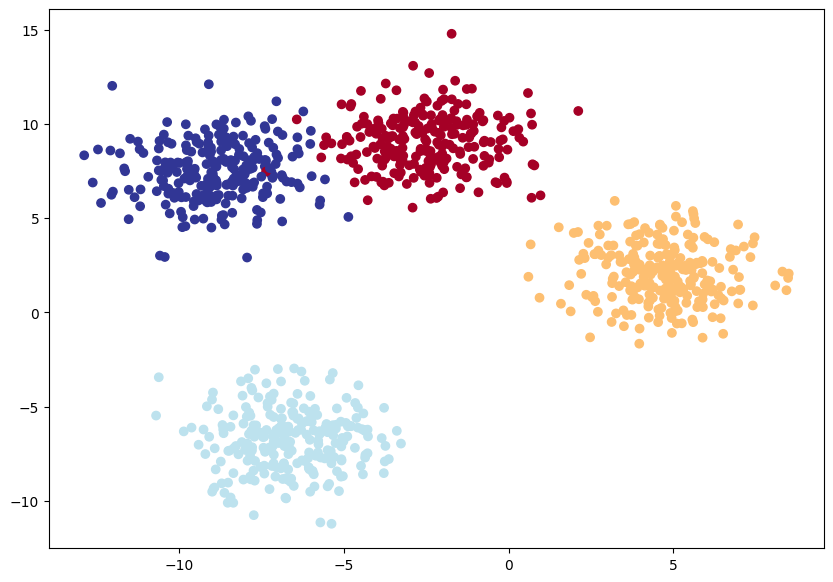

In [140]:
from sklearn.datasets import make_blobs
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5,
    random_state=RANDOM_SEED
)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

In [141]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
        
device = 'cuda' if torch.cuda.is_available() else 'cpu'
blob_model = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blob_model.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(1, epochs+1):
    blob_model.train()
    y_logits = blob_model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blob_model.eval()
    with torch.inference_mode():
        test_logits = blob_model(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 10 | Loss: 0.66986, Acc: 96.38% | Test Loss: 0.68530, Test Acc: 97.00%
Epoch: 20 | Loss: 0.44530, Acc: 98.38% | Test Loss: 0.45176, Test Acc: 100.00%
Epoch: 30 | Loss: 0.26957, Acc: 99.12% | Test Loss: 0.26331, Test Acc: 99.50%
Epoch: 40 | Loss: 0.12142, Acc: 99.25% | Test Loss: 0.11084, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06876, Acc: 99.25% | Test Loss: 0.06091, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05175, Acc: 99.25% | Test Loss: 0.04402, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04359, Acc: 99.25% | Test Loss: 0.03556, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03875, Acc: 99.25% | Test Loss: 0.03028, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03551, Acc: 99.25% | Test Loss: 0.02690, Test Acc: 99.50%
Epoch: 100 | Loss: 0.03331, Acc: 99.25% | Test Loss: 0.02453, Test Acc: 99.50%


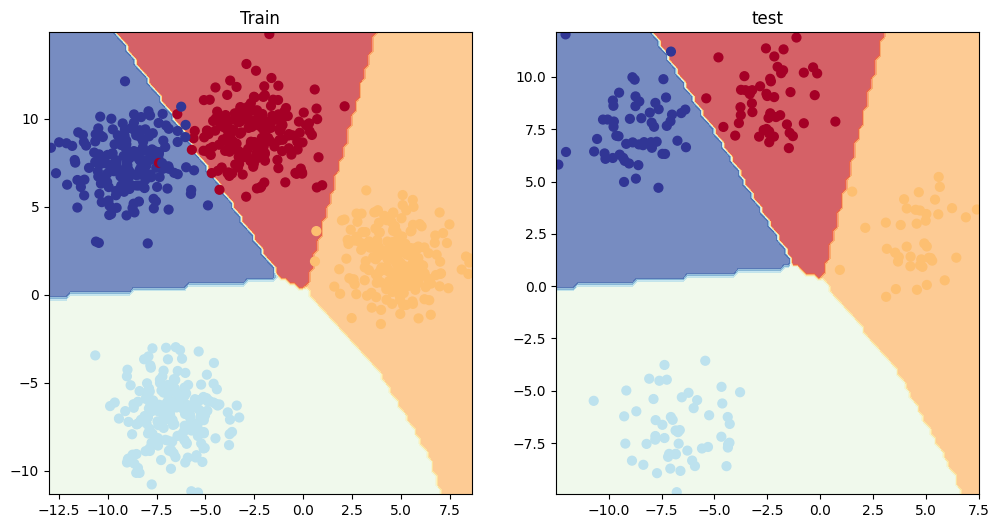

In [143]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)